### imports

In [1]:
import sqlite3  
import pandas as pd  
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 


In [2]:
import dtale
import pandas_profiling as pp
import sweetviz as sv
import autoviz as av

In [3]:
 # Create your connection.  
cnx = sqlite3.connect('ml_db.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx) 

In [4]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
# dtale.show(df1)

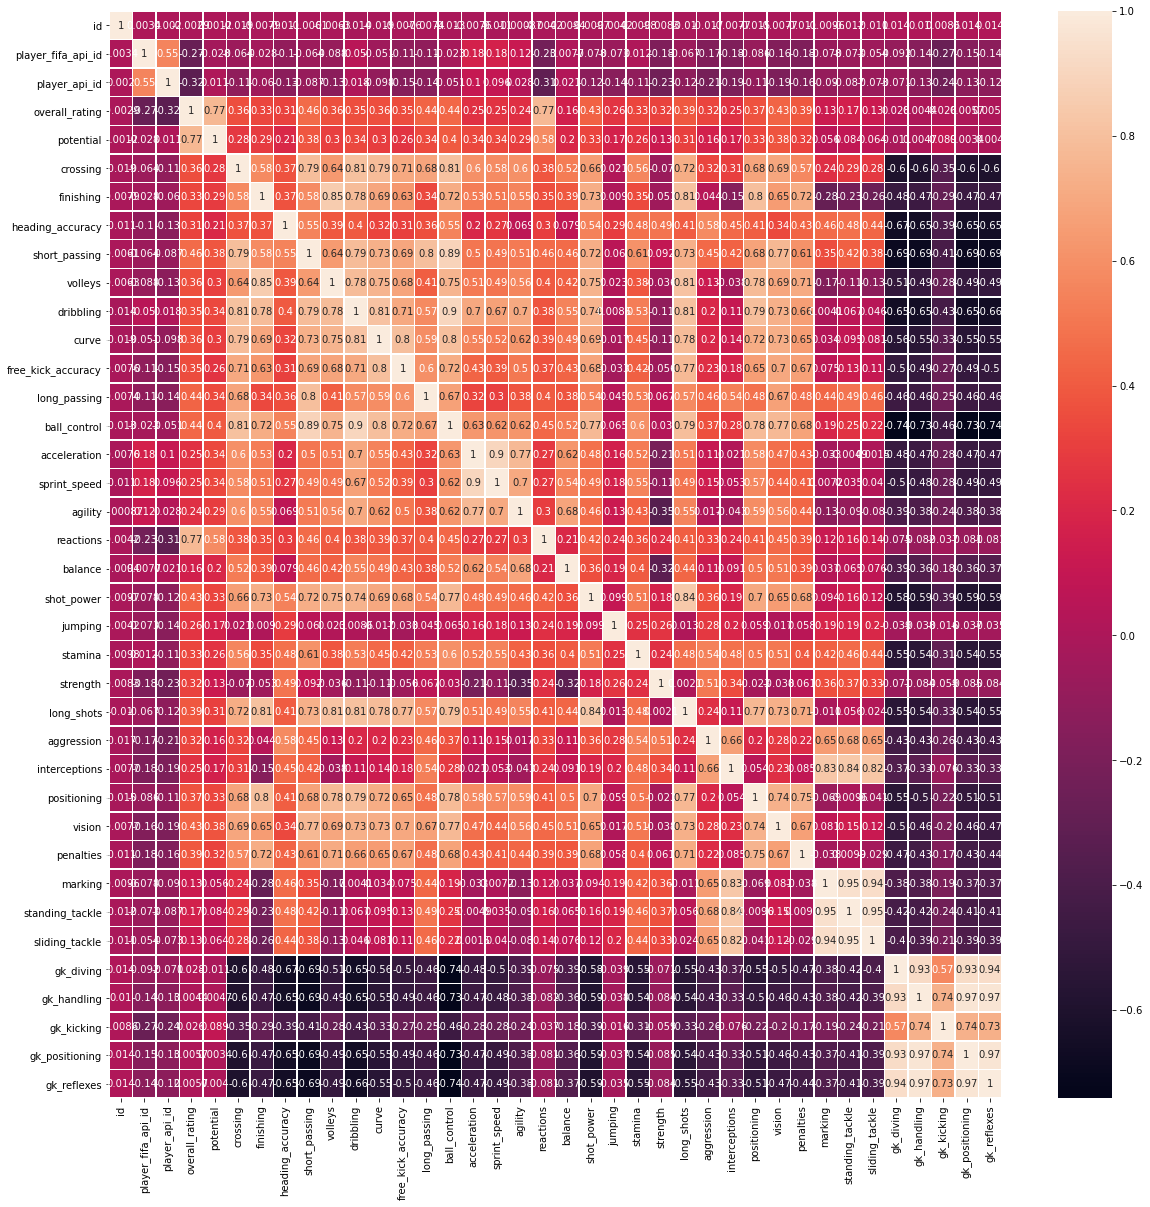

In [6]:
# df.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
ax = sns.heatmap(df.corr(), annot=True, linewidths=.5)

In [7]:
df1 = df.dropna().copy()

In [8]:
df1.corr().overall_rating


id                   -0.003738
player_fifa_api_id   -0.278703
player_api_id        -0.328315
overall_rating        1.000000
potential             0.765435
crossing              0.357320
finishing             0.330079
heading_accuracy      0.313324
short_passing         0.458243
volleys               0.361739
dribbling             0.354191
curve                 0.357566
free_kick_accuracy    0.349800
long_passing          0.434525
ball_control          0.443991
acceleration          0.243998
sprint_speed          0.253048
agility               0.239963
reactions             0.771856
balance               0.160211
shot_power            0.428053
jumping               0.258978
stamina               0.325606
strength              0.315684
long_shots            0.392668
aggression            0.322782
interceptions         0.249094
positioning           0.368978
vision                0.431493
penalties             0.392715
marking               0.132185
standing_tackle       0.163986
sliding_

In [9]:
cols = []
for i,j in zip(df.corr()['overall_rating'] > 0.2,df.corr().columns):
    if i == True:
        cols.append(j)
        

In [10]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
encode.fit(df1['preferred_foot'])
df1["preferred_foot"] = encode.transform(df1['preferred_foot'])
# df1['preferred_foot'].unique()


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df1.drop(columns=['overall_rating','id','player_fifa_api_id','player_api_id','date']))
X_scaled = scaler.fit_transform(df1[cols])

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)

In [13]:
y = df1.overall_rating

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x_pca, y, test_size=0.2, random_state=44)

In [15]:
reg = LinearRegression()
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

0.900888107375211

In [16]:
dreg = DecisionTreeRegressor()
dreg.fit(x_train,y_train)
dreg.score(x_test,y_test)

0.9412388553295616

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(dreg, x_pca, y, cv=10)

array([0.874236  , 0.86502493, 0.86718302, 0.86624504, 0.85757825,
       0.86790742, 0.87457705, 0.8589005 , 0.86960054, 0.87242343])

In [18]:
cross_val_score(reg, x_pca, y, cv=10)

array([0.90539624, 0.90468226, 0.89842872, 0.89498409, 0.89673411,
       0.89309164, 0.91091987, 0.89790196, 0.90125583, 0.9053923 ])

In [19]:
from sklearn.model_selection import ShuffleSplit

ss_ind = list()
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for train_index, test_index in ss.split(x_pca):
    ss_ind.append((train_index, test_index))

In [20]:
scores = list()
for i,j in ss_ind:
    reg = LinearRegression()
    reg.fit(x_pca[i],y.iloc[i])
    scores.append(reg.score(x_pca[j],y.iloc[j]))

#     reg.score(x_test,y_test)
scores

[0.9003616562950603,
 0.9007937765618672,
 0.9016901754529323,
 0.901794351610778,
 0.9000955629912906]

In [21]:
def shuffle_model(model,x,y):
    ss_ind = list()
    scores = list()
    # initiaze
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    # get train, test index values by shuffle split
    for train_index, test_index in ss.split(x):
        ss_ind.append((train_index, test_index))
    # run it with the model
    for i,j in ss_ind:
        model.fit(x_pca[i],y.iloc[i])
        scores.append(model.score(x_pca[j],y.iloc[j]))
    print(scores)

### random forest has 96% accuracy, 96 in shuffle split and 93 in cross val score

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
# shuffle_model(model,x_pca,y)

In [25]:
# shuffle_model(dreg,x_pca,y)

In [27]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
# shuffle_model(model,x_pca,y)
# cross_val_score(model, x_pca, y, cv=10)

In [28]:
import xgboost as xgb

In [29]:
xreg = xgb.XGBRegressor()

In [30]:
shuffle_model(xreg,x_pca,y)

[0.9425007502339543, 0.9423764916530244, 0.9440994072543198, 0.9431489627251357, 0.9425179829300936]


In [31]:
from lightgbm import LGBMRegressor

lxreg = LGBMRegressor()
shuffle_model(lxreg,x_pca,y)

[0.94001590658994, 0.9400327959205227, 0.9413401449256682, 0.9405700921758481, 0.9398616351024242]
